anormal span detected
tensor([-0.0507], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[0.5258, 0.4752]], device='cuda:0', grad_fn=<SqueezeBackward1>)
min max
[0.7284151 0.9650775] [0.8016254 0.992193 ]
3.30M Parameters


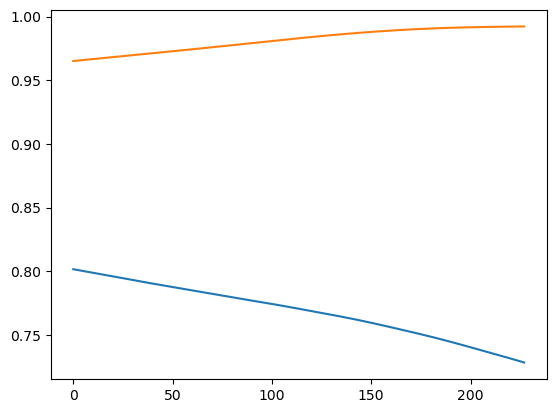

In [18]:
PATH = "/media/maxine/c8f4bcb2-c1fe-4676-877d-8e476418f5e5/0-RPE-cell-timelapse/"
from modules.learning.models import *
from modules.learning.train import train_model
from modules.utils import hc
from modules.visualize import plot_loss, plot_normalized_time_error

# from modules.learning.evaluate import Evaluation, get_latent_space, plot_umap
from matplotlib import pyplot as plt
from modules.learning.dycep import DYCEP
import json

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# enet = EfficientNet()


track_path = PATH + "track_datasets/control_mm/train/images/"
label_path = PATH + "track_datasets/control_mm/train/labels/"

in_channels = [1]

model = DYCEP(cnn_in_channels = len(in_channels))
model.to(DEVICE)

#########
# test on one track
#########

track_name = "0607.1629.npy"
# getting one sequence to check the model
imgs = torch.tensor(
    np.load(track_path + track_name, allow_pickle=True),
    dtype=torch.float32,
)[:, in_channels, :, :]


label = torch.tensor(
    np.load(label_path + track_name).reshape(2, -1).T,
    dtype=torch.float32,
)

imgs, label = imgs.to(DEVICE), label.to(DEVICE)

zz = model.forward(imgs[None, :, :, :])
zz= zz.detach().cpu().numpy().squeeze()
plt.plot(zz)
print("min max")
print(zz.min(0), zz.max(0))
print(hc(model), "Parameters")


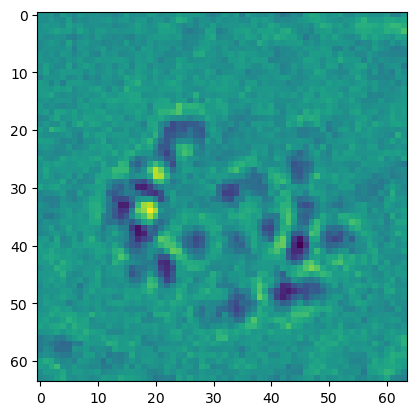

In [19]:
imgs.shape
imgs = torch.tensor(
    np.load(track_path + track_name, allow_pickle=True),
    dtype=torch.float32,
)[:, :, :, :]

plt.imshow(imgs[50, 1, :, :].detach().cpu().numpy())

dict_keys(['number', 'path', 'name', 'model_type', 'img_channels', 'batch_size', 'num_epochs', 'learning_rate', 'train_loss', 'test_loss', 'train_R2', 'test_R2'])


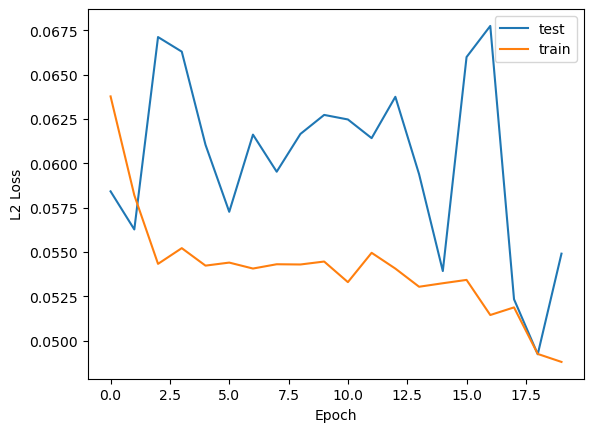

In [20]:
model_number = 54

conf_path = f"weights/config-{model_number}.json"

# load dict in .json file
with open(conf_path, "r") as file:
    config = json.load(file)

img_channel = config['img_channels']

print(config.keys())
plt.plot(config["test_loss"], label="test")
plt.plot(config["train_loss"], label="train")

plt.ylabel("L2 Loss")
plt.xlabel("Epoch")

plt.legend()

dict_keys(['number', 'path', 'name', 'model_type', 'img_channels', 'batch_size', 'num_epochs', 'learning_rate', 'train_loss', 'test_loss', 'train_R2', 'test_R2'])


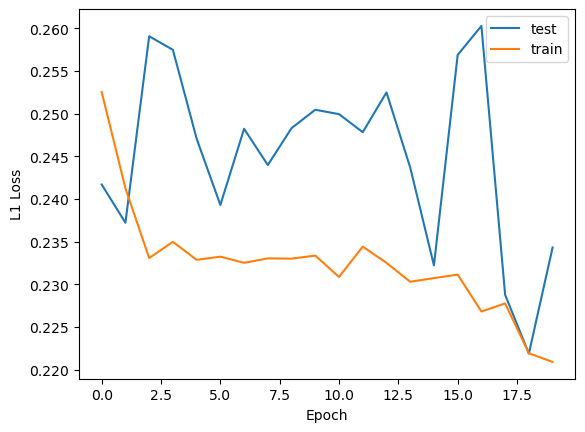

In [21]:
print(config.keys())

l1_train = np.sqrt(config["train_loss"])
l1_test = np.sqrt(config["test_loss"])

plt.plot(l1_test, label="test")
plt.plot(l1_train, label="train")

plt.ylabel("L1 Loss")
plt.xlabel("Epoch")

plt.legend()

In [23]:
from modules.learning.evaluate import Evaluation

model.load_state_dict(torch.load(f"weights/model-{model_number}.pt"))


<All keys matched successfully>

In [31]:
# eval_subpath = "datasets/Palbociclib/"
# eval_subpath = "datasets/Control/test/"
eval_subpath = "track_datasets/control_mm/test/"

eval = Evaluation()
eval.fit(
    PATH + eval_subpath, model, img_channels=img_channel, smoothing=True
)

100%|██████████| 358/358 [00:06<00:00, 55.40it/s]


----------------------------------------------------------------------
Model Performance:
\ell_1: 0.075 ± 0.030
\ell_2: 0.017 ± 0.019
W_d: 0.057 ± 0.020
Accuracy: 0.884 ± 0.070



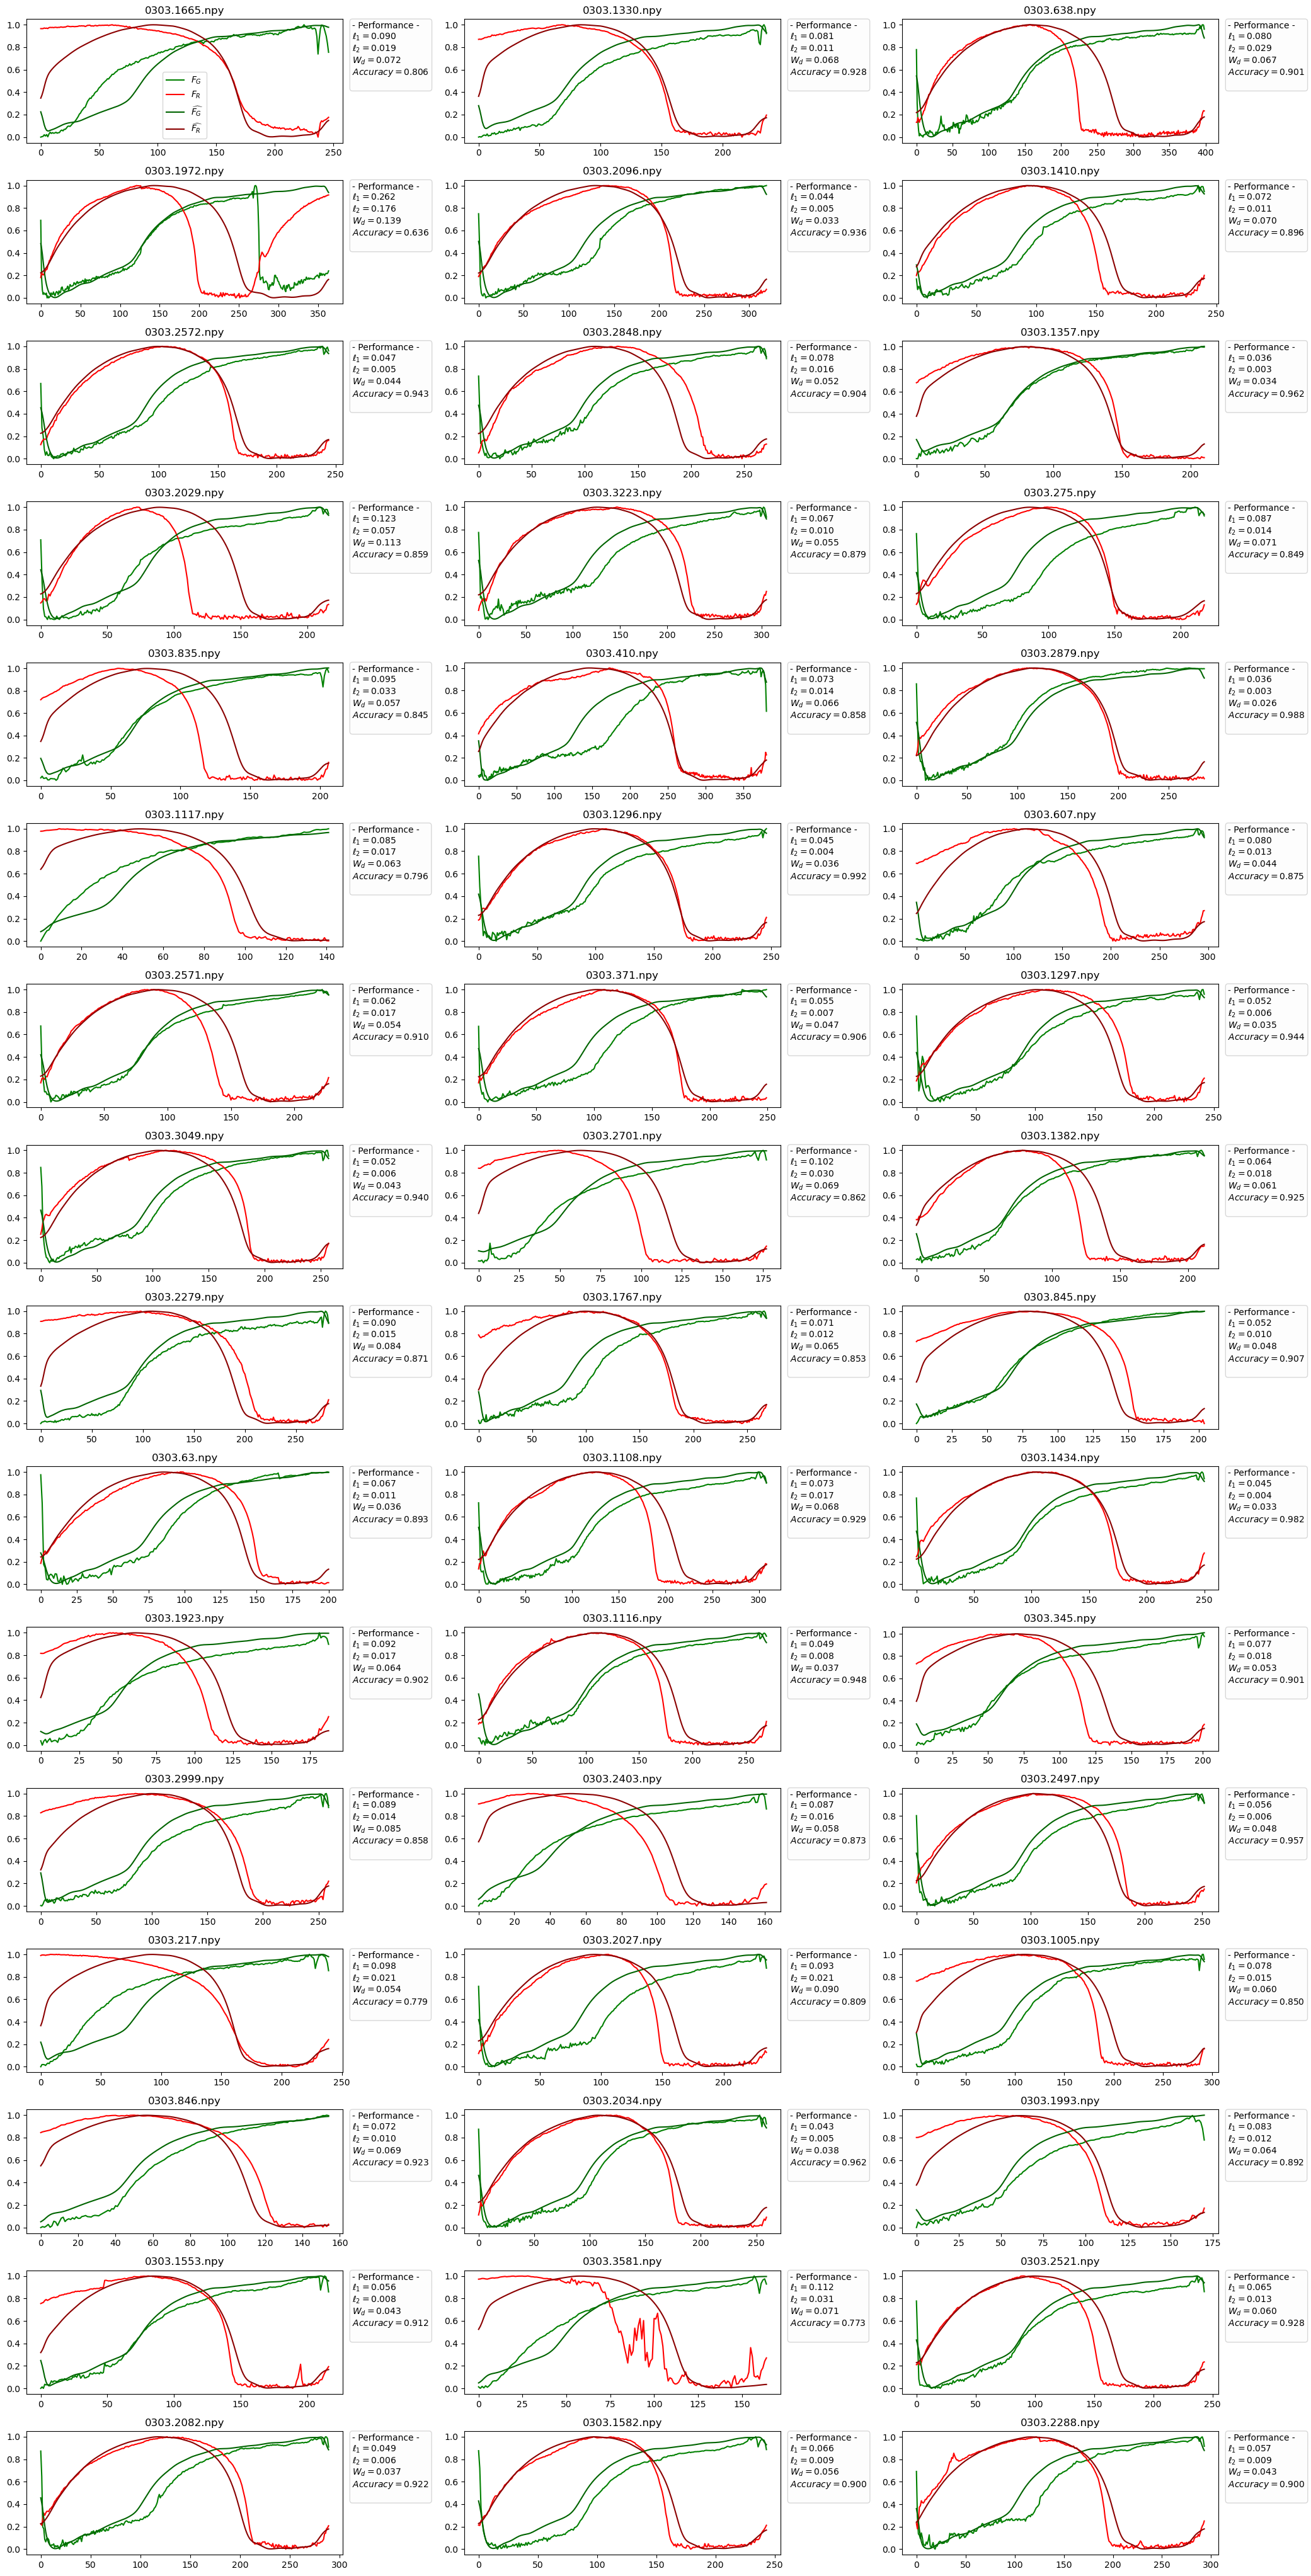

In [32]:
print(eval.summary())
eval.visualize_predicted_tracks(50)

In [33]:
eval.prediction_df.columns


Index(['CELL_ID', 'y', 'y_hat', '\ell_1', '\ell_2', 'W_d', 'Accuracy'], dtype='object')

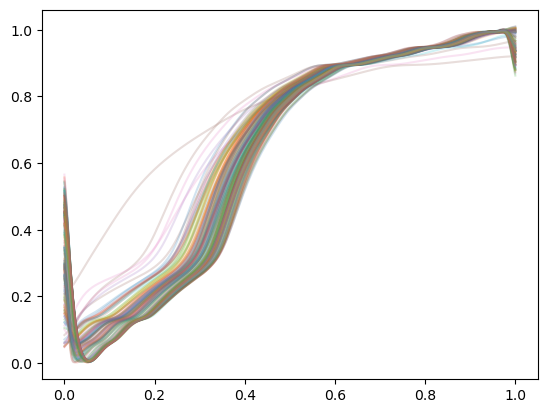

In [34]:
for i in range(200):
    track = eval.prediction_df.y_hat[i]
    tau = np.linspace(0, 1, track.shape[0])
    plt.plot(tau, track[:, 0], alpha=0.2)

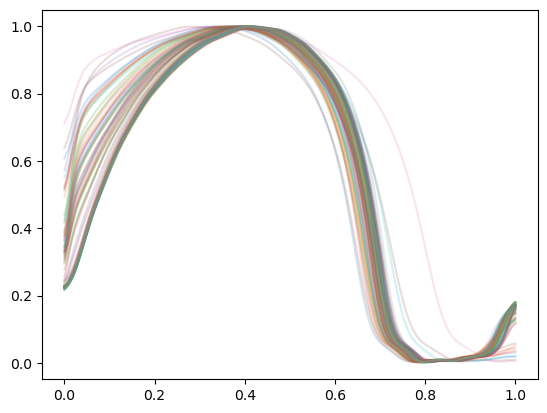

In [35]:
for i in range(100):
    track = eval.prediction_df.y_hat[i]
    tau = np.linspace(0, 1, track.shape[0])
    plt.plot(tau, track[:, 1], alpha=0.2)

# get phases

In [36]:
import os
from tqdm import tqdm

In [ ]:
slice_p = 1.
random_len = True
slice_len = 10

# this is a copied and adapted function that gets random slices from the sequnces
# 

def random_slice(imgs, labels, random_len=True, slice_len=10):

    if random_len:
        slice_len = np.random.randint(slice_len, labels.shape[0] - 1)
    x = np.random.randint(0, labels.shape[0] - slice_len)
    return (
        imgs[x : x + slice_len],
        labels[x : x + slice_len],
    )  # minimum 2h of images

In [51]:
img_directory = PATH + "track_datasets/control_mm/test/images/"
label_directory = PATH + "track_datasets/control_mm/test/labels/"
cells = os.listdir(img_directory)[:]
# Initialize pandas cells so we can store tracks inside
# model.to(DEVICE)

ph = []
label = []
prediction = []
for idx, cell in enumerate(tqdm(cells)):
    # Get input with specific image channels and groundtruth FUCCI signal
    x = (
        torch.tensor(
            np.load(img_directory + cell, allow_pickle=True),
            dtype=torch.float32,
        )[:, [1], :, :]
        .to(DEVICE)
    )
    lab = np.load(label_directory + cell).reshape(2, -1).T


    if np.random.rand() < slice_p and lab.shape[0] > slice_len:
        x, lab = random_slice(x, lab)

    x = model.spatial_encoder(x.unsqueeze(0))
    x = model.temporal_encoder(model.fc_s2t(x))
    x = model.get_phi(x)
    pred = model.vanilla_fn(x)

    ph.append(x.detach().cpu().numpy().squeeze())
    label.append(lab)
    prediction.append(pred.detach().cpu().numpy().squeeze())

  3%|▎         | 10/358 [00:00<00:07, 47.93it/s]

anormal span detected
tensor([-0.0106], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[0.6860, 0.6754]], device='cuda:0', grad_fn=<SqueezeBackward1>)


  8%|▊         | 28/358 [00:00<00:06, 53.30it/s]

anormal span detected
tensor([-0.0247], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[0.6986, 0.6740]], device='cuda:0', grad_fn=<SqueezeBackward1>)


 11%|█         | 40/358 [00:00<00:06, 51.37it/s]

anormal span detected
tensor([-0.0018], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[0.6692, 0.6674]], device='cuda:0', grad_fn=<SqueezeBackward1>)


 52%|█████▏    | 185/358 [00:03<00:02, 61.17it/s]

anormal span detected
tensor([-0.0171], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[0.7005, 0.6835]], device='cuda:0', grad_fn=<SqueezeBackward1>)


 67%|██████▋   | 240/358 [00:04<00:01, 59.87it/s]

anormal span detected
tensor([-0.0293], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[0.7014, 0.6722]], device='cuda:0', grad_fn=<SqueezeBackward1>)


100%|██████████| 358/358 [00:06<00:00, 58.29it/s]

anormal span detected
tensor([-0.0146], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[0.7052, 0.6906]], device='cuda:0', grad_fn=<SqueezeBackward1>)


In [52]:
ph0 = [p[0] for p in ph]
ph_fn = [p[-1] for p in ph]

print(f"ph 0 mean {np.mean(ph0)} std {np.std(ph0)}")
print(f"ph fin mean {np.mean(ph_fn)} std {np.std(ph_fn)}")
print(f"ph 0 min {np.min(ph0)} max {np.max(ph0)}")
print(f"ph fin min {np.min(ph_fn)} max {np.max(ph_fn)}")


ph 0 mean 0.17759327590465546 std 0.1903204321861267
ph fin mean 0.844872772693634 std 0.12475687265396118
ph 0 min 0.0002884015266317874 max 0.7052282094955444
ph fin min 0.6522192358970642 max 0.9995248317718506


Text(0.5, 0, 'Normalized Time')

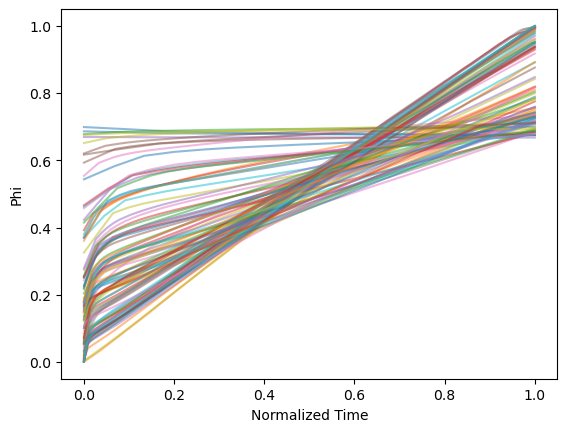

In [53]:
for i in range(100):
    plt.plot(np.linspace(0, 1, len(ph[i])), ph[i], alpha=0.5)

plt.ylabel("Phi")
plt.xlabel("Normalized Time")

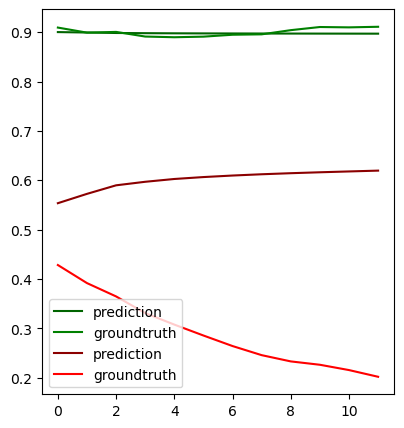

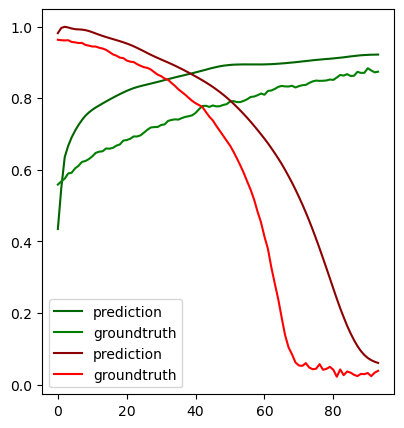

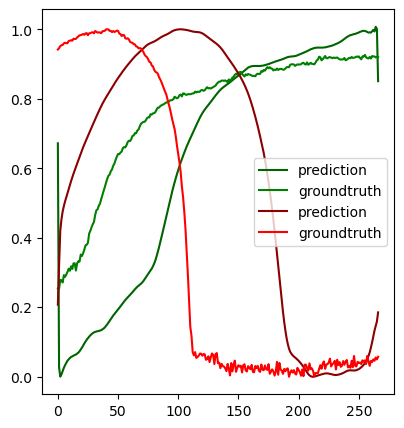

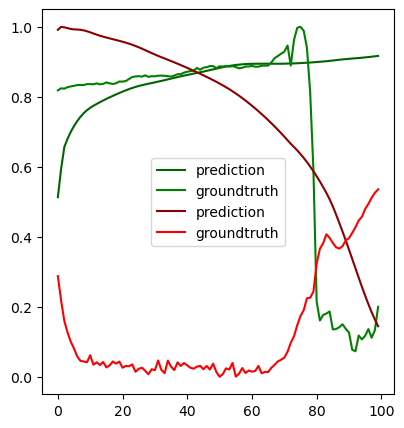

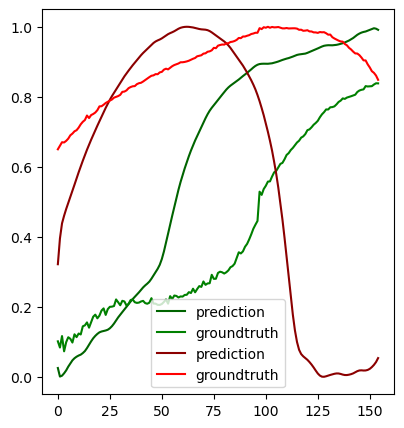

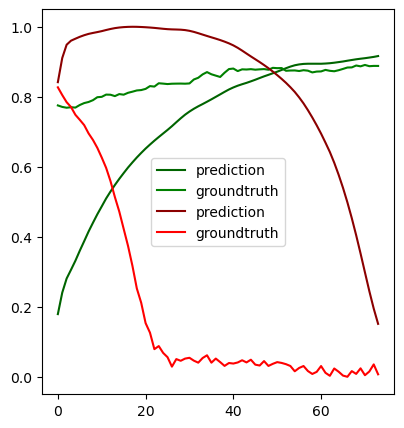

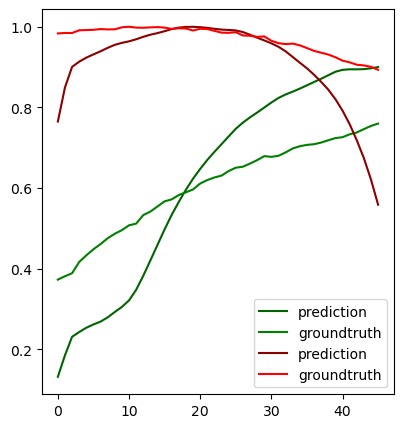

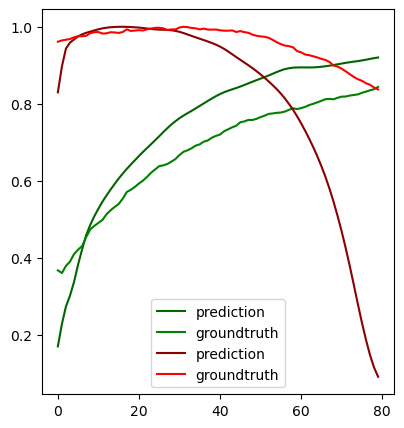

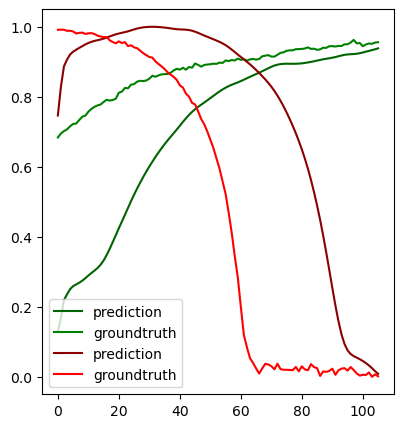

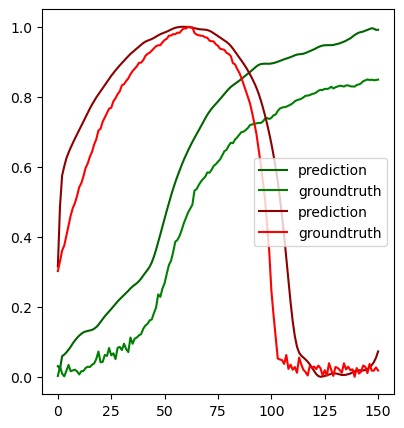

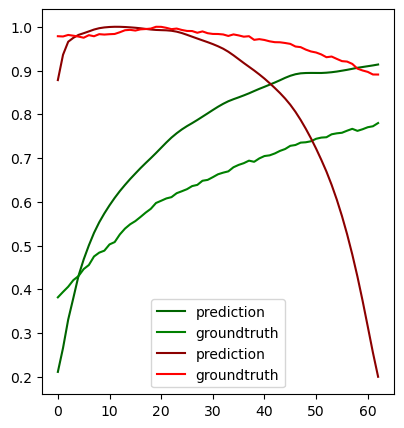

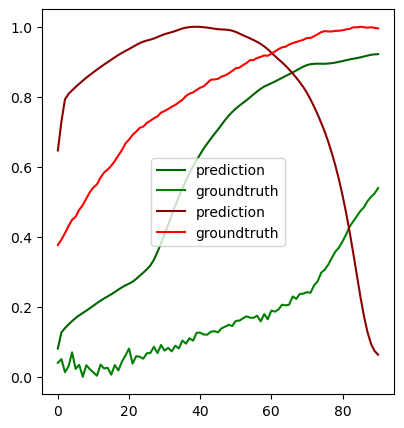

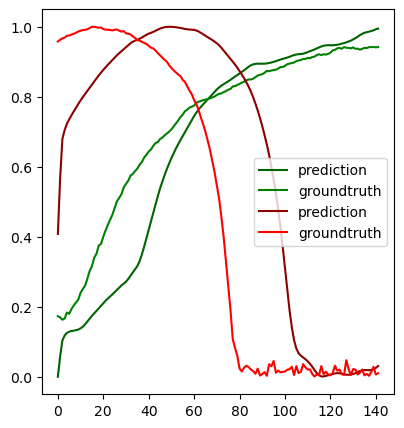

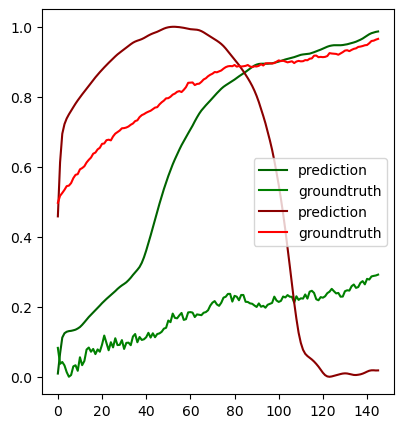

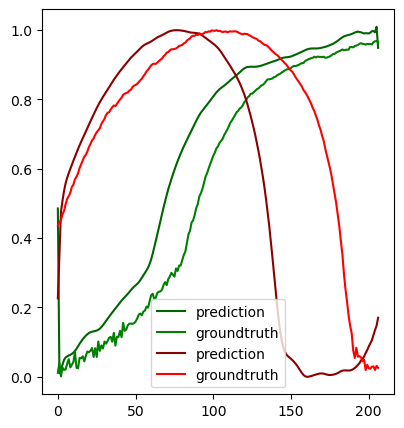

In [56]:
for i in range(15):
    tau = np.linspace(0, 1, len(label[i]))
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)

    plt.plot(prediction[i][:,0], "darkgreen", label="prediction")
    plt.plot(label[i][:,0], "green",  label="groundtruth")
    plt.plot(prediction[i][:,1], "darkred", label="prediction")
    plt.plot(label[i][:,1], "red",  label="groundtruth")

    plt.legend()

    # plt.subplot(1, 2, 2)

    # plt.plot(ph[i], prediction[i][:,0], "darkgreen", label="prediction")
    # plt.plot(tau, label[i][:,0], "green",  label="groundtruth")
    # plt.plot(ph[i], prediction[i][:,1], "darkred", label="prediction")
    # plt.plot(tau, label[i][:,1], "red",  label="groundtruth")


    # plt.legend()
    # plt.show()